In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd /content/drive/MyDrive/hate_speech/models

/content/drive/MyDrive/hate_speech/models


In [3]:
! pip install transformers==4.2.0

     |████████████████████████████████| 1.8 MB 5.3 MB/s eta 0:00:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.2.0
    Uninstalling transformers-4.2.0:
      Successfully uninstalled transformers-4.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 2.2.2 requires transformers<5.0.0,>=4.6.0, but you have transformers 4.2.1 which is incompatible.
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import torch.nn as nn
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import time
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback
     

In [3]:
# Set the seed value all over the place to make this reproducible.
seed_val = 1234

random.seed(seed_val)
torch.manual_seed(seed_val)

In [9]:
def do_tokenize(csv, tokenizer):
    '''
    run the tokenizer, pad the sequence
    '''
    X, y = list(csv["tweet"]), list(csv["label"])
    # calculate max length of the tweets
    max_length = 0
    for x in X:
        ids = tokenizer.encode(x)
        max_length = max(len(ids),max_length)
    X_tokenized = tokenizer(X, padding=True, truncation=True, max_length=max_length)
    return X_tokenized, y

In [17]:
# Define pretrained tokenizer and model
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.

In [18]:
train_csv = pd.read_csv('../data/Davidson/train.csv', names=['label','tweet'],header=0)
dev_csv = pd.read_csv('../data/Davidson/dev.csv', names=['label','tweet'], header=0)
X_train, y_train = do_tokenize(train_csv, tokenizer)
X_dev, y_dev = do_tokenize(train_csv, tokenizer)

In [19]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, device=DEVICE):
        self.encodings = encodings
        self.labels = labels
        self.device = device

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(self.device) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx]).to(self.device)
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train, y_train)
dev_dataset = Dataset(X_dev, y_dev)

In [23]:
# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average = "weighted")
    precision = precision_score(y_true=labels, y_pred=pred, average = "weighted")
    f1 = f1_score(y_true=labels, y_pred=pred, average = "weighted")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [51]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=1000,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    seed=1234,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

In [ ]:
# Train pre-trained model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Runtime,Samples Per Second
1000,0.530500,0.655526,0.783668,0.710392,0.783668,0.711327,657.180400,30.168000
2000,0.654200,0.641265,0.788863,0.716324,0.788863,0.732930,658.783900,30.095000
3000,0.661900,0.653267,0.789721,0.717845,0.789721,0.734626,658.541700,30.106000
4000,0.656500,0.637465,0.789468,0.717529,0.789468,0.733279,657.561800,30.151000
5000,0.635100,0.513780,0.840059,0.802060,0.840059,0.819502,654.995500,30.269000
6000,0.438400,0.449252,0.834762,0.828818,0.834762,0.822296,662.008300,29.948000
7000,0.463200,0.445004,0.836376,0.827713,0.836376,0.823280,660.709000,30.007000
8000,0.688900,0.667556,0.773126,0.597724,0.773126,0.674204,654.547300,30.290000
9000,0.681500,0.668009,0.773126,0.597724,0.773126,0.674204,656.437200,30.202000


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

In [27]:
# test
test_csv = pd.read_csv('../data/Davidson/test.csv', names=['label','tweet'], header=0)
X_test, y_test = do_tokenize(test_csv, tokenizer)
test_dataset = Dataset(X_test, y_test)

In [29]:
# Load trained model
model_path = "output/checkpoint-2000"
trained_model = BertForSequenceClassification.from_pretrained(model_path, num_labels=3)

In [30]:
# Define tester
tester = Trainer(trained_model)

In [44]:
# Make prediction
raw_pred, _, _ = tester.predict(test_dataset)

In [32]:
# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [33]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.         0.49019608 0.50980392]
 [0.         0.88525441 0.11474559]
 [0.         0.0775     0.9225    ]]


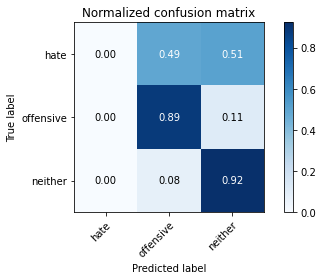

In [36]:
plot_confusion_matrix(y_test, y_pred, classes = ["hate","offensive","neither"], normalize=True, title='Normalized confusion matrix')

Confusion matrix, without normalization
[[   0   75   78]
 [   0 1705  221]
 [   0   31  369]]


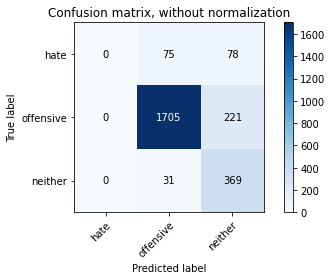

In [38]:
plot_confusion_matrix(y_test, y_pred, classes = ["hate","offensive","neither"], normalize=False, title='Confusion matrix, without normalization')

In [37]:
print(classification_report(y_test, y_pred, target_names=["hate","offensive","neither"]))

              precision    recall  f1-score   support

        hate       0.00      0.00      0.00       153
   offensive       0.94      0.89      0.91      1926
     neither       0.55      0.92      0.69       400

    accuracy                           0.84      2479
   macro avg       0.50      0.60      0.53      2479
weighted avg       0.82      0.84      0.82      2479



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
